In [ ]:
import os
import numpy as np
import rasterio
from src import pipeline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress
from datetime import datetime
from scipy import stats
from scipy.ndimage import distance_transform_edt
from datetime import date
import glob
import pandas as pd

### Read Classification Stack

In [ ]:
def get_class_stack(
        classified_folder_path = "output/classified/",
        classified_name_format = "*_classified.tif",
        ):
    """Opens all classification images, returns as a single stack"""
    # ---------------------------------
    # 1. Input setup
    # ---------------------------------
    files = sorted(glob.glob(os.path.join(classified_folder_path, 
                                          classified_name_format)))
    
    filenames = [os.path.basename(f) for f in files]

    # ---------------------------------
    # 2. Read and stack rasters (classifications)
    # ---------------------------------
    class_stack = []
    meta = None
    for f in files:
        with rasterio.open(f) as src:
            data = src.read(1)
            class_stack.append(data)
            if meta is None:
                meta = src.meta

    class_stack = np.stack(class_stack, axis=0)  # shape: (time, H, W)
    #H, W = stack.shape[1:]

    return class_stack, filenames

### Read Landsat images and calculate NDVI

In [184]:

def calculate_NDVI(
        output_shape,
        img_folder_path = "data/stacked/",
        ):
    """ Opens all images in img_folder_path, calculates NDVI, returns as a stack """
    ndvi_stack = np.empty(output_shape,np.float32)
    #ndvi_stack.dtype == np.float32



    for n, img_name in enumerate(os.listdir(img_folder_path)):

        img_path = img_folder_path + img_name + "/" + img_name
        with rasterio.open(img_path) as src:
            bands, band_names, band_to_index, profile = pipeline.get_bands_from_stack(img_path)

            sensor = img_name[0:4]
            #img = src.read()
            #profile = src.profile
            #rgb = reshape_as_image(img)[:, :, :3]  # for display
            #transform = src.transform
            red = bands[band_to_index[pipeline.band_map[sensor]['R']] - 1]
            nir = bands[band_to_index[pipeline.band_map[sensor]['NIR']] - 1]

            ndvi = np.where(
                    (nir + red) == 0, np.nan,
                    (nir - red) / (nir + red)
                )
            ndvi_stack[n, :, :] = ndvi

    return ndvi_stack


### Get dates of each image (as integer in days)

In [191]:
def dates_convert(filenames):
    
    dates_str = [y.split("_")[3] for y in filenames]
    dates_dt = np.array([datetime.strptime(dt, '%Y%m%d') for dt in dates_str])
    dates_int = dates_dt.astype('datetime64[D]').astype(float)

    return dates_dt, dates_int

### Calculate NDVI trend in each pixel

In [193]:
def basic_regression(x,y):
    x_mean = x.mean()
    y_mean = y.mean()
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
    intercept = y_mean - slope * x_mean
    return slope, intercept

def calculate_trend(
        class_stack,
        index_stack,
        dates_int,
        min_datapoints_for_reg = 5
):
    
    """Calculates linear trend of a given index in every jungle pixel.
    Requires classified stack and index stack
    Returns slope and intercept of each regression, also saved as a stack
    """ 

    H, W = class_stack.shape[1:]

    trend_stack = np.empty(class_stack.shape[1:],np.float32)
    intercept_stack = np.empty(class_stack.shape[1:],np.int16)

    for y in range(H):

        for x in range(W):
            s = class_stack[:,y,x]
            ndvi_s = index_stack[:,y,x]
            s_filter = ((s == 1) & ~np.isnan(ndvi_s))
            if s_filter.sum() < min_datapoints_for_reg:
                trend_stack[y,x] = np.nan
                continue
            ndvi_filt = ndvi_s[s_filter]
            dates_filt = dates_int[s_filter]
            slope_xy, intercept_xy = basic_regression(dates_filt,ndvi_filt)
            trend_stack[y,x] = slope_xy
            intercept_stack[y,x] = intercept_xy

        # print progress
        if y % 100 == 99:
            comp_perc = int(100*y/H)
            print(f"{comp_perc}% complete")

    return trend_stack, intercept_stack

        


### Get final classification state from file

In [194]:
def get_final_state(
        path = "output/classified/jungle_to_mine_change.tif"
):
    with rasterio.open(path) as src:
        initial_state = src.read(1)
        final_state = src.read(2)
        change_year = src.read(3)

    final_state_no_forest = final_state.astype(float)
    forest_mask = (final_state==1)
    final_state_no_forest[forest_mask] = np.nan 

    return final_state, final_state_no_forest

### Plot NDVI trends on a map

In [195]:
def plot_index(
        trend_stack,
        final_state_no_forest,
        scaling = 365*13, #make it over the 13-year period,
        save_path = None
):
    """ Plot index, with the final states overlayed."""

    # Define the boundaries (edges between color ranges)
    bounds = [-9999, -0.15, -0.05,  0.05, 0.15, 9999]

    # Define the colors for each range (one fewer than the number of bounds)
    colors = ['#e66158', '#f4a582', "#F3E8B3", '#b8e186', '#4d9221']

    # Create colormap and normalization
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    trend_stack_scaled = trend_stack*scaling 

    # Plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow((trend_stack_scaled), cmap=cmap, norm=norm) 
    plt.colorbar(im, boundaries=bounds, ticks=bounds[1:-1], label="NDVI Change")
    plt.title("NDVI Trend Map \n(modelled change between 2013 and 2025)")


    classes = {
        3: ("Ocean", "deepskyblue"),
        0: ("Cloud", "lightgrey"),
        1: ("Jungle", "forestgreen"),
        2: ("Cleared", "black"),
        -1: ("No data", "darkblue")
    }

    # Sort class values to match colormap
    class_values = sorted(classes.keys())
    class_colors = [classes[c][1] for c in class_values]
    #class_labels = [classes[c][0] for c in class_values[2:3]]

    # Create colormap and norm
    class_cmap = mcolors.ListedColormap(class_colors)
    # Boundaries should extend ±0.5 around each integer value
    class_bounds = [c - 0.5 for c in class_values] + [class_values[-1] + 0.5]
    class_norm = mcolors.BoundaryNorm(class_bounds, class_cmap.N)

    # Plot
    im = plt.imshow(final_state_no_forest, cmap=class_cmap, norm=class_norm)
    #cbar = plt.colorbar(im, ticks=class_values)
    #cbar.ax.set_yticklabels(class_labels)

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
    return



### Calculate distance to mine site (using final state)

In [196]:
def calculate_distance(
    final_state,
    plot_dist = False
):
    """ Calculate distance from each jungle pixel (state = 1) to the nearest cleared pixel (2)"""
    # Boolean mask of "2" pixels
    mask_2 = (final_state == 2)

    # Compute Euclidean distance from every pixel to the nearest "2" pixel
    dist_to_2 = distance_transform_edt(~mask_2)

    # Mask so only class 1 pixels show distance (others as NaN)
    dist_plot = np.full_like(dist_to_2, np.nan, dtype=float)
    dist_plot[final_state == 1] = dist_to_2[final_state == 1]

    if plot_dist:
        #Plot 
        plt.figure(figsize=(8, 8))
        im = plt.imshow(dist_plot, cmap='viridis')
        plt.colorbar(im, label='Distance to nearest class 2 (pixels)')
        plt.title('Distance to nearest mine')
        plt.show()

    return dist_plot

In [197]:
def pixel_regression(
        classified_folder_path = "output/classified/",
        classified_name_format = "*_classified.tif",
        img_folder_path = "data/stacked/",
        min_datapoints_for_reg = 5,
        change_tif_path = "output/classified/jungle_to_mine_change.tif",
        plot_index_toggle = True,
        plot_index_path = None,
        plot_dist_toggle = False,
        index_scaling = 365*13,
):
    class_stack, filenames = get_class_stack(classified_folder_path ,classified_name_format)

    index_stack = calculate_NDVI(class_stack.shape, img_folder_path)

    _, dates_int = dates_convert(filenames)

    trend_stack, intercept_stack = calculate_trend(class_stack, index_stack, dates_int, min_datapoints_for_reg)

    final_state, final_state_no_forest = get_final_state(change_tif_path)

    if plot_index_toggle:
        plot_index(trend_stack, final_state_no_forest, index_scaling, plot_index_path)
    
    
    dist_plot = calculate_distance(final_state, plot_dist_toggle)
    
    return trend_stack, intercept_stack, dist_plot    
    


C:\Users\oneil\AppData\Local\Temp\ipykernel_9952\1132442018.py:27: RuntimeWarning: invalid value encountered in divide
  (nir - red) / (nir + red)


7% complete
15% complete
23% complete
30% complete
38% complete
46% complete
54% complete
61% complete
69% complete
77% complete
85% complete
92% complete


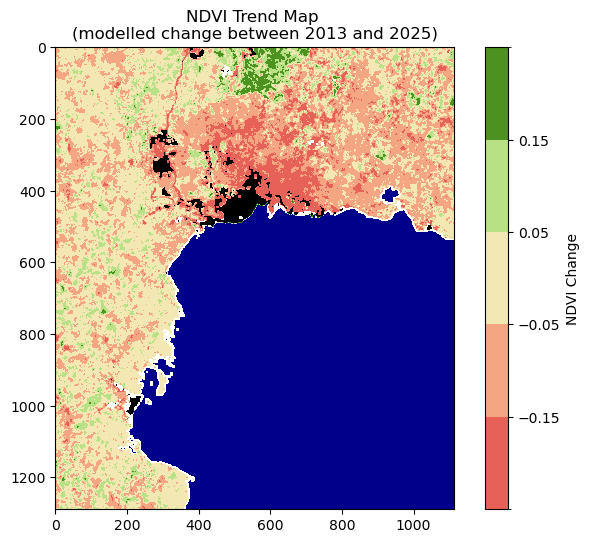

In [198]:
trend_stack, intercept_stack, dist_plot = pixel_regression()

### Calculate relationship between NDVI and distance to a mine

Slope: 4.9626730246785766e-05
Intercept: -0.04390067047775285
R-squared: 0.002646946774467095
P-value: 0.0


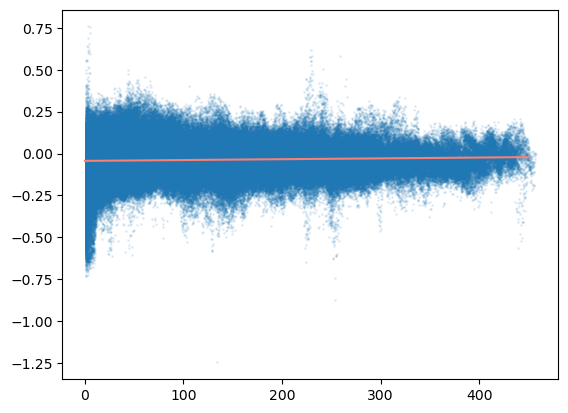

In [155]:


# Flattened arrays
x = dist_plot.flatten()
y = trend_stack_scaled.flatten()

plt.scatter(x,y, alpha = 0.1,s=1)

# Remove NaNs
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

r_squared = r_value**2

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")
print(f"P-value: {p_value}")

reg_line_max = 450

plt.plot([0,reg_line_max],[intercept,intercept+slope*reg_line_max], c = 'salmon')


### Explore seasonality

[10,
 2,
 6,
 11,
 5,
 10,
 12,
 5,
 7,
 10,
 2,
 5,
 9,
 12,
 1,
 3,
 1,
 4,
 6,
 10,
 5,
 7,
 10,
 11,
 3,
 5,
 12,
 7,
 10,
 12,
 2,
 5,
 10,
 2,
 7]

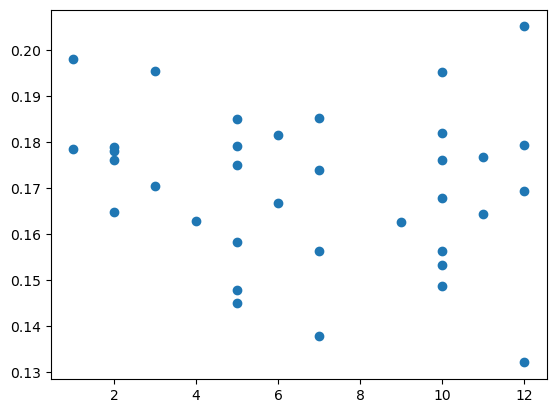

In [180]:
y = np.nanmean(ndvi_stack, axis = (1,2))
x = [dt.month for dt in dates_dt]

plt.scatter(x,y)

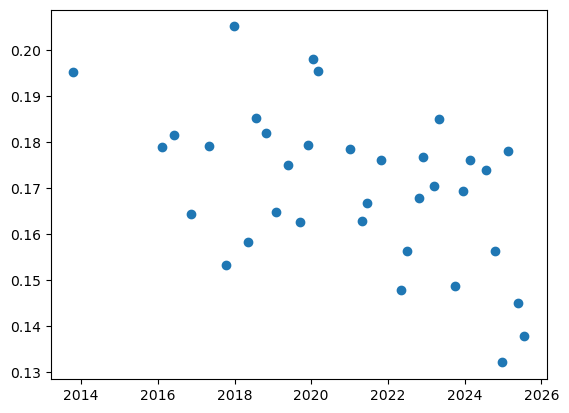

In [181]:
y = np.nanmean(ndvi_stack, axis = (1,2))
x = dates_dt

plt.scatter(x,y)